# T-matrix code for calculating reflectance and transmittance of a multilayered dielectric stack (1D photonic crystal) for both TE and TM polarization

***

* Original code written by Prof. Naresh Emani in 2016. Follows the formulation in the textbook, "Pochi Yeh Optical waves in layered media", Ch. 5 - Matrix Formulation for Isotropic Layered Media

* Adapted by Dr. Jinal Tapar to validate 1D Photonic Crystal


***

***
**Example #1**
Example to calculate the reflectivity for the bandstructure given in the textbook Photonic Crystals by J Joannopoulos et. al. -  Ch 4. p 51, Fig 5 GaAs-Air multilayer stack

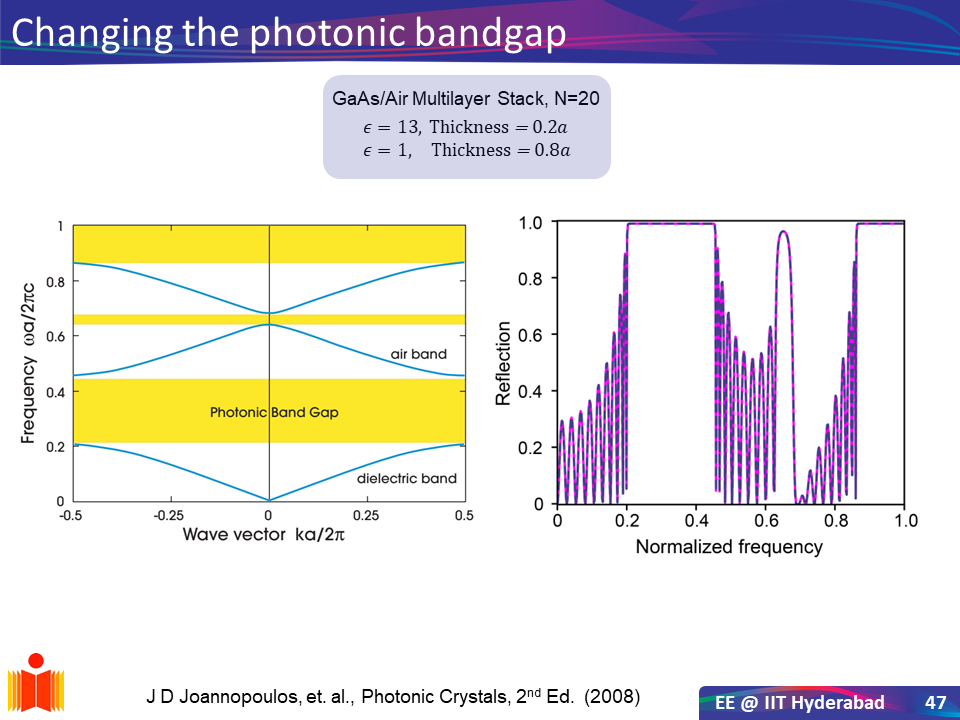

***

In [ ]:
######################################################
################ Routine definitions #################
######################################################

from IPython import get_ipython
get_ipython().magic('reset -sf')
get_ipython().magic('clear')

import sys, os, time
import numpy as np, matplotlib.pyplot as plt, seaborn as sb
from numpy import pi; from scipy.interpolate import interp1d; from matplotlib.gridspec import GridSpec
plt.rcParams['figure.figsize']=(8,4)

nm=1e-9;
um=1e-6;
c=3e8;


In [ ]:
######################################################
################## User Inputs #######################
######################################################
  
############################ Reflection multilayer p 337, Fig 8.8.2 #######################################
#=============== Calculate TM and TE reflectances for nH = sqrt(13), nL = 1 ============
###########################################################################################################

NUM_LAYERS = 20               # Enter the number of layers excluding substrate and superstrate
n_SUP = 1.0                   # Should be real
n_SUB = 1.0                  # Should be real

lam0 =500*nm                  # Free space wavelength
nH = np.sqrt(13)                     # High refractive index   
nL = 1                     # low refractive index

a = np.linspace(0.001,1,500)*lam0

ANG=np.array([0,0,80])*pi/180
WVL = np.linspace(500,800,501)*nm


n_SLAB = np.zeros(NUM_LAYERS)
di = np.zeros(NUM_LAYERS)

if NUM_LAYERS==0:
    P1 = np.eye(2)
    P2 = np.eye(2)

RRR= np.zeros(shape=(2,len(a)) , dtype = float)                  # TM/TE pol, lambda, inc_angle
TTT = np.zeros(shape=(2,len(a)) , dtype = float)
AAA = np.zeros(shape=(2,len(a)) , dtype = float)
ttt = np.zeros(shape=(2,len(a)) , dtype = complex)
rrr = np.zeros(shape=(2,len(a)) , dtype = complex)
Dp_sub = np.zeros(shape=(2,2) , dtype = complex) 
Dp_sup = np.zeros(shape=(2,2) , dtype = complex)
Ds_sub = np.zeros(shape=(2,2) , dtype = complex)
Ds_sup = np.zeros(shape=(2,2) , dtype = complex)

omega=c/WVL

for idx1 in range(len(a)):
    dH = a[idx1]/5         #  thickness of high index layer
    dL = a[idx1]*4/5         #  thickness of low index layer
    
    for i in range(NUM_LAYERS):
        if i%2==0:
            n_SLAB[i] = nH
            di[i] = dH
        else:
            n_SLAB[i] = nL
            di[i] = dL
        
        theta0 = ANG[0]
        lam = WVL[0]
#         Calculate dynamic matrices of substrate and superstrate
        theta_sub = np.arcsin(np.sin(theta0)*n_SUP/n_SUB)

#       TM or p polarization
        Dp_sup = np.array([[np.cos(theta0), np.cos(theta0)], [n_SUP, -n_SUP]])
        Dp_sub = np.array([[np.cos(theta_sub), np.cos(theta_sub)], [n_SUB, -n_SUB]])

#       TE Polarization
        Ds_sup = np.array([[1, 1], [n_SUP*np.cos(theta0), -n_SUP*np.cos(theta0)]])
        Ds_sub = np.array([[1, 1], [n_SUB*np.cos(theta_sub), -n_SUB*np.cos(theta_sub)]])
                            
#        % Calculate the dynamical and propagation matrices for intermediate layers
        P1i = np.eye(2 , dtype = complex) 
        P2i = np.eye(2 , dtype = complex) 

        for idx3 in range(NUM_LAYERS):
                      
            n = n_SLAB[idx3]                
            d = di[idx3]
            
            theta=np.arcsin(np.sin(theta0)*n_SUP/n);    
            kx = n*2*pi*np.cos(theta)/lam;
#            Propagation matrix
#            P=[exp(j*kx*d),0;0,exp(-j*kx*d)];
            Prop = np.array([[np.exp(1j*kx*d), 0], [0,np.exp(-1j*kx*d)]])
#            Dynamical matrix for TM polarization
            Dp = np.array([[np.cos(theta), np.cos(theta)], [n, -n]])
            
#            Dynamical matrix for TE Polarization
            Ds = np.array([[1, 1], [n*np.cos(theta), -n*np.cos(theta)]])

            
            Dp_inv = np.linalg.solve(Dp, np.eye(2)) 
            Ds_inv = np.linalg.solve(Ds, np.eye(2)) 
            
            P1i = P1i.dot(Dp).dot(Prop).dot(Dp_inv)
            P2i = P2i.dot(Ds).dot(Prop).dot(Ds_inv)
            
        P1 = P1i
        P2 = P2i
#       Perform calculation by matrix inversion. INV(A) can be
#       unstable and give RCOND warning. Backslash or MLDIVIDE
#       performs calculation in a better way and provides more
#       numerical stability
        
#        Mp=np.linalg.lstsq(Dp_sup,np.dot(P1,Dp_sub))[0]     # Return only solution...ignoring residuals
#        Ms=np.linalg.lstsq(Ds_sup,np.dot(P2,Ds_sub))[0]
        
        Mp=np.linalg.solve(Dp_sup,np.dot(P1,Dp_sub))     # Return only solution...ignoring residuals
        Ms=np.linalg.solve(Ds_sup,np.dot(P2,Ds_sub))
#
##        %Calculate R & T for p polarization
        rrr[0,idx1]= Mp[1,0]/Mp[0,0]
        ttt[0,idx1]= 1/Mp[0,0]
        RRR[0,idx1]=abs(rrr[0,idx1])**2;
        TTT[0,idx1]=(n_SUB*np.cos(theta_sub))/(n_SUP*np.cos(theta0))*abs(ttt[0,idx1])**2
        
##        %Calculate R & T for s polarization
        rrr[1,idx1]= Ms[1,0]/Ms[0,0]
        ttt[1,idx1]= 1/Ms[0,0]
        RRR[1,idx1]=abs(rrr[1,idx1])**2;
        TTT[1,idx1]=(n_SUB*np.cos(theta_sub))/(n_SUP*np.cos(theta0))*abs(ttt[1,idx1])**2
                


<ipython-input-8-b3da6be91a60>:76: RuntimeWarning: invalid value encountered in double_scalars
  theta=np.arcsin(np.sin(theta0)*n_SUP/n);
<ipython-input-8-b3da6be91a60>:108: RuntimeWarning: invalid value encountered in cdouble_scalars
  rrr[0,idx1]= Mp[1,0]/Mp[0,0]
<ipython-input-8-b3da6be91a60>:109: RuntimeWarning: invalid value encountered in cdouble_scalars
  ttt[0,idx1]= 1/Mp[0,0]
<ipython-input-8-b3da6be91a60>:114: RuntimeWarning: invalid value encountered in cdouble_scalars
  rrr[1,idx1]= Ms[1,0]/Ms[0,0]
<ipython-input-8-b3da6be91a60>:115: RuntimeWarning: invalid value encountered in cdouble_scalars
  ttt[1,idx1]= 1/Ms[0,0]


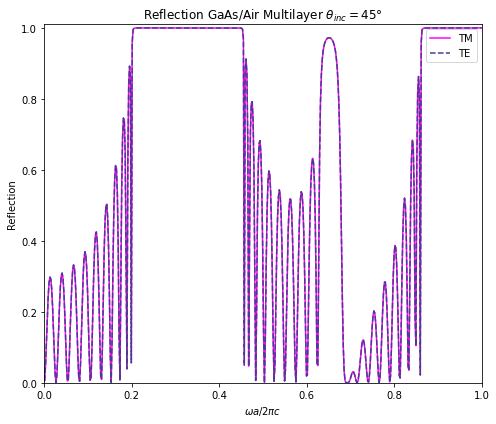

In [ ]:
fig = plt.figure(figsize=(7,6))
plt.title("Reflection GaAs/Air Multilayer $\u03B8_{inc} = 0\u00b0$")
plt.plot(a/lam0, RRR[0,:], label='TM', color='magenta', linestyle='-')
plt.plot(a/lam0, RRR[1,:], label='TE', color='darkslateblue', linestyle='--')
plt.ylabel('Reflection')
plt.xlabel('$\omega a/2\pi c$')
plt.xlim([0, 1.0])
plt.ylim([0, 1.01])
plt.legend()  
plt.tight_layout()
plt.savefig("1D_photonic bandgap_20p_duty_cycle.svg")